# Quantum Walk Search Algorithm

Quantum walks are the quantum equivalence of a classical Markov chain and have become key in many quantum algorithms. In this section, we implement a quantum walk search algorithm that finds marked elements in a graph. The algorithm has a quadratic speedup compared to its classical counterpart. 

## 1.Classical Markov chains <a name="markov"></a>
A Markov chain is a stochastic process often used to model real-life processes. It consists of states and associated transition probabilities, which describe the probabilities to move between the states in each time step. In discrete-time Markov chains, which we work with here, the time steps are discrete. Markov chains satisfy the Markov property, which means that the next step of the process only depends on the current and not any of the previous steps. A Markov chain has an associated transition matrix, P, which describes the probability to move between each of the states. We show an example of a Markov chain and its associated transition matrix $P$ below. 
\begin{equation}
P=
\begin{pmatrix}
0.1 & 0.3 & 0.3\\
0.1 & 0.1 & 0.2 \\
0.8 & 0.6 & 0.5
\end{pmatrix}
\label{eq:matrix_example}
\end{equation}
<img src="images/markov_example.png" width='480'>

Given a transition matrix $P$, we can obtain the probability distribution after $t$ time steps by $P^t$.

## 2.Quantum walks <a name="qwalks"></a>
Quantum walks are the quantum equivalent of the classical Markov chain. Due to superposition, a quantum walk will take all possible paths simultaneously until we measure the circuit. Due to quantum interference, some state will cancel out. This makes quantum walk algorithms faster than classical ones, since we can design them in such way that wrong answers quickly cancel out. There are two common models for quantum walks, coined quantum walks and Szegedy quantum walks, which are equivalent under certain circumstances. A coined quantum walk is a walk on the vertices of the graph while Szegedy quantum walk takes place on the edges. Before we show how we can implement a quantum walk, we will introduce both models. 

 $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
 $\newcommand{\bra}[1]{\left\langle{#1}\right|}$
### 2.A Coined quantum walks <a name="coined"></a>
A simple example of a coined quantum walk is a walk on the infinite integer line. In this case, we represent the walker's position with an integer, $\{\ket{j} : j \in  \mathbb{Z} \}$, since the walker can walk all integers in $\mathbb{Z}$. A coin decides how the walker should move. On the integer line, the walker can go either left or right. Therefore, the coin's computational basis is $\{\ket{0}, \ket{1}\}$, and we move the walker in one direction if the coin is $\ket{0}$ and in the other direction if the coin is $\ket{1}$. 

A coined quantum is a walk on the nodes in a graph, and we refer to the nodes as states. The walker can move between states that are connected with an edge. In the coin model, we have two quantum states and two operators. The first state is the position state, which represents the walker's position. For the walk above, this is an integer since the walker can be anywhere on the integer line. The other state is the coin state. The coin state decides how the walker should move in the next step. We can represent both the coin state and the position state by vectors in Hilbert space. If we can express the coin state by a vector in $\mathcal{H}_C$ and the position state with a vector in $\mathcal{H}_P$, we can express the quantum space for the entire walker as $\mathcal{H} = \mathcal{H}_C \otimes \mathcal{H}_P$. 

As we mentioned, the model also has two operators; the coin operator, $C$, and the shift operator, $S$. The coin operator acts on $\mathcal{H}_C$ during each time step and puts the walker in superposition, so it walks all possible paths simultaneously. For the walk on the integer line, this means that it moves both to the left and right in each time step. There are different coin operators, but the most common ones are the Hadamard coin and the Grover coin. A Hadamard coin is a Hadamard gate that puts the walker in an equal superposition: 

\begin{equation}
    H = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1 
\end{bmatrix}
\end{equation}

A Grover coin is the Grover diffusion operator from Grover's algorithm. We define it as 

\begin{equation}
    G = 
    \begin{bmatrix}
\frac{2}{n} -1 & \frac{2}{n} & \ldots & \frac{2}{n}\\
\frac{2}{n} & \frac{2}{n} - 1  & \ldots & \frac{2}{n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{2}{n} & \frac{2}{n} & \ldots & \frac{2}{n} -1
\end{bmatrix}
\end{equation}

Like the Hadamard coin, a Grover coin puts the walker in superposition. However, it behaves a bit differently. If we apply a Grover coin to a walker in position $\ket{000}$, we obtain the state vector probabilities shown in the figure below. As we can see, the coin does not put the walker in an equal superposition as the Hadamard coin does. Instead, $\ket{000}$ has a much larger probability than the other states. 

<img src="images/grover_prob.svg" width='480'>

The other operator in the model, the shift operator, acts on $\mathcal{H}_P$ and moves the walker to the next position. For the walk on the integer line, the shift operator moves the walker to the left of the coin is $\ket{0}$ and to the right if the coin is $\ket{1}$: 

\begin{equation}
    S \ket{0}\ket{j} = \ket{0}\ket{j+1}
\end{equation}

\begin{equation}
    S \ket{1}\ket{j} = \ket{1}\ket{j-1}
\end{equation}


With the shift operator defined as above, we can represent one step of the coined quantum as the unitary operator $U$ given by
\begin{equation}
    U = SC,
\end{equation}

where C is the coin operator. For the quantum walk on the integer line we use the Hadamard coin, but C can be either Hadamard coin, Grover coin or any other coin operator.


We can also look several steps ahead. We can express the quantum state $\ket{\psi}$ after $t$ time steps as
\begin{equation}
    \ket{\psi (t)} = U^t \ket{\psi(0)},
\end{equation}
where $\ket{\psi(0)}$ is the initial state and U is the operator for one step of the walk [1]. 

Coined quantum walks are most suitable for regular graphs, graphs where all nodes have the same number of neighbors [2]. An alternative quantum walk model that is more convenient for non-regular graphs is the Szegedy model that we will look at next. 

### 2.B Szedgedy quantum walk <a name="szegedy"></a>
While a coined walk is a walk on the graph's nodes, a Szegedy walk is a walk on the edges on a bipartite double-cover of the original graph. The double-cover graph is a graph with twice as many vertices as the original graph. Two nodes in the bipartite double-cover graph are connected with an edge if and only if the nodes are also connected in the original graph. To create this model, we start with the transition probability matrix P for the classical walk. As described in section 1, we represent a classical discrete-time random walk by a transition matrix $P$. For any $N$-vertex graph with $N \times N$ transition matrix $P$, we can define the corresponding discrete-time quantum walk as a unitary operation on the Hilbert space $\mathcal{H}^N \otimes \mathcal{H}^N$. Let $P_{jk}$ define the probability that we make a transition from state $j$ to $k$. Before we define the walk, we define the normalized states 

\begin{equation}
    \ket{\psi_j} := \sum_{k=1}^N \sqrt{P_{kj}} \ket{j,k}, \; j=1,...,N
\end{equation}

and the projection onto ${\ket{\psi_j}}:j=1,...,N$

\begin{equation}
    \Pi := \sum_{j=1}^N \ket{\psi_j} \bra{\psi_j}
\label{eq:sz_pi}
\end{equation}

We also introduce the shift operator S:

\begin{equation}
    S := \sum_{j,k=1}^N \ket{j,k} \bra{k,j}
\label{eq:sz_s}
\end{equation}

With $S$ and $\Pi$ defined as above we can introduce one step of the discrete-time quantum walk:

\begin{equation}
    U := S(2 \Pi - 1),
\label{eq:sz_op}
\end{equation}

where $(2 \Pi - 1)$ is the reflection operator. We also define $t$ steps of the walk as $U^t$ [2]. 

### 2.C Equivalence of coined and Szegedy quantum walks <a name="equivalence"></a>
It is known that a coined walk with Grover coin is equivalent to Szegedy quantum walk. For more details, we refer to this article [3] by Thomas G. Wong, where he also shows the equivalence between the operators in the two models. 


## 3. Example: Implementing quantum walk on a hypercube <a name="example1"></a>
A hypercube is the $n$-dimensional counterpart of the $3$-dimensional cube. All nodes have degree $n$, and the hypercube has a total of $N=2^n$ nodes. We can represent the nodes in a hypercube graph by $n$-tuples of binary numbers. The binary representation of the neighbors of a node will differ by only one binary number. For example, in the 4-dimensional hypercube, the neighbors to $0000$ are $0001$, $0010$, $0100$, and $1000$. Thus, a node is connected to all nodes to which the Hamming distance is 1. The edges are also labeled. Two neighboring nodes that differ in the a:th bit are connected by the edge labeled $a$.

The Hilbert space representing a coined quantum walk on the hypercube is $\mathcal{H} = \mathcal{H}^n \otimes \mathcal{H}^{2^n}$, where $\mathcal{H}^n$ denotes the coin space and $\mathcal{H}^{2^n}$ the walker's position. The computational basis is

\begin{equation}
    \big\{ \ket{a,\vec{v}}, 0 \leq a \leq n-1, \vec{v} \in  \{(00...00), (00...01), ....., (11...11 )\} \big\}. 
\end{equation}

The value of the coin computational basis $a$, which is associated with edge $a$, decides where the walker should move. If the $a=0$, the walker will go to the node where the first binary value differs from the current node. If $a=1$, the walker will move to the node in which the second value differs from the current, et cetera.  Let $\vec{e}_a$ be an n-tuple where all binary values, except the value with index $a$, are $0$. Then the shift operator $S$ moves the walker from the state $\ket{a} \ket{\vec{v}}$ to $\ket{\vec{v} \oplus \vec{e}_a}$:

\begin{equation}
    S \ket{a} \ket{\vec{v}} = \ket{a} \ket{\vec{v} \oplus \vec{e}_a}.
\end{equation}

We use the Grover coin, $G$, for this walk. Thus, the evolution operator is

\begin{equation}
    U = SG.
\end{equation}

We will now show how we can implement a quantum walk on a 4-dimensional hypercube. We need to implement the coin operator and the shift operator. We start by importing all necessary libraries from Qiskit. 

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

The circuit will have 6 qubits, 4 that represents the position and 2 that represents the coin. As we mentioned previously, the coin is a Grover coin, which is the diffuser in Grover's algorithm. We start by implementing this. 

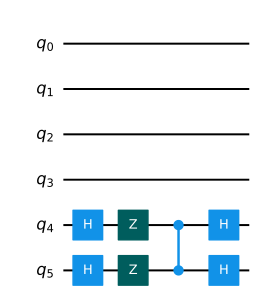

In [2]:
one_step_circuit = QuantumCircuit(6, name=' ONE STEP') 
# Coin operator
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])
one_step_circuit.draw() 

Now, let us implement the shift operator. We know that the walker can only move to neighboring nodes, and all neighboring nodes differ by only one bit. We want to move the walker according to the coin, and we move the walker by applying a NOT gate to one of the node qubits. If the coin is in state $\ket{11}$, we move the walker to the state in which the first node qubit differ. If the coin is $\ket{10}$ or $\ket{01}$, the walker moves to the state where the second and third qubit, respectively, differ. Finally, if the Grover coin is $\ket{00}$, we flip the fourth qubit. We implement this with CCNOT- and NOT gates after the Grover coin. Together, they are one step of a quantum walk on a 4-dimensional hypercube. 

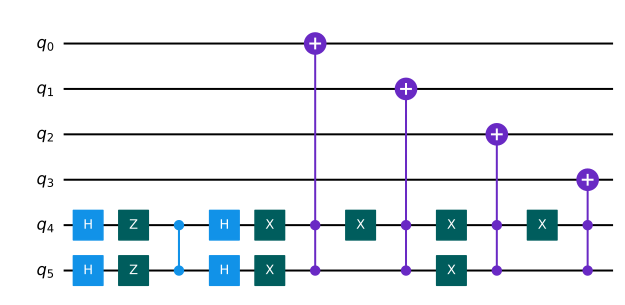

In [3]:
# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,4):
        circuit.x(4)
        if i%2==0:
            circuit.x(5)
        circuit.ccx(4,5,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw() 

## 4. Quantum walk search algorithm <a name="qwalkalgo"></a>
We will now implement a quantum walk search algorithm that finds a marked vertex in a graph. First, we describe the algorithm, then we go through its implementation. The quantum walk search algorithm solves the problem of finding marked vertices in a graph by a quantum walk. That is, we mark some set of vertices $|M|$, start at an arbitrary node in the graph and move according to the walk until we find the marked nodes. The basis states in the quantum walk search algorithm have two registers, one corresponding to the current node and the other corresponding to the previous node. That is, the basis states corresponds to the edges in the graph. We denote the quantum walk based on the classical Markov chain with transition matrix $P$ by the unitary operation $W(P)$ on $\mathcal{H}$. We also define $\ket{p_x} = \sum_y \sqrt{P_{xy}}\ket{y}$ as the uniform superposition over the node $x$'s neighbors. Let $\ket{x}\ket{y}$ be a basis state. We define the basis state $\ket{x}\ket{y}$ as ''good'' if $x$ is a marked node. Otherwise, we refer to it as ''bad''. We now introduce ''good'' and ''bad'' states: 

\begin{equation}
    \ket{G} = \frac{1}{\sqrt{|M|}} \sum_{x \in M} \ket{x} \ket{p_x}, \;
    \ket{B} = \frac{1}{\sqrt{N-|M|}} \sum_{x \notin M} \ket{x} \ket{p_x},
\end{equation}

which are the superpositions over good and bad basis states. Next, let us define $\epsilon = |M|/N$ and $\theta = \arcsin(\sqrt{\epsilon})$.


In short, the algorithm consists of three steps: 


1. Set up the initial state $\ket{U} = \frac{1}{\sqrt{N}} \sum_{x} \ket{x} \ket{p_x} = \sin{\theta} \ket{G} + \cos{\theta} \ket{B}$, a uniform superposition over all edges
2. Repeat $O(1/\sqrt{\epsilon})$ times: 
    
    (a) Reflect through $\ket{B}$
    
    (b) Reflect through $\ket{U}$

3. Do a measurement in the computational basis 


We can easily implement step $1$ with Hadamard gates and the reflection through $\ket{B}$ with a phase oracle that shifts the phase of $x$ if $x$ is in the first register, and leaves the circuit unchanged otherwise. 


Step 2(b) is equivalent to finding a unitary $R(P)$ that performs the following mapping: 
\begin{align}
\label{eq:mapping_1}
    \ket{U} &\mapsto \ket{U}, \: \text{and} \\
    \ket{\psi} &\mapsto -\ket{\psi}, \: \forall \ket{\psi} \text{in the span of eigenvectors of $W(P)$ that are orthogonal to $\ket{U}$}
\label{eq:mapping_2}
\end{align}

To find this operator we apply phase estimation on $W(P)$. Above we defined $W(P)$ as the evolution operator for the random walk. As we saw in section 2.A, this is a unitary operator. From this follows that the eigenvalues of $W(P)$ have norm $1$. Because of this, we can write the eigenvalues of $W(P)$ on the form $e^{\pm 2i\theta_j}$. The unitary $W(P)$ has one eigenvector with corresponding eigenvalue $1$, which is $\ket{U}$. This is given by $\theta_1=0$. $R(P)$ will find this vector $\ket{U}$ by adding a register with auxiliary qubits and perform phase estimation with precision $O(1/\sqrt{\delta})$, where $\delta$ is the spectral gap of $P$. To do this, we need to apply $W(P)$ $O(1/\sqrt{\delta})$ times. Let $\ket{w}$ be an eigenvector of $W(P)$ with eigenvalue $e^{\pm 2i\theta_j}$. Assume that $\tilde{\theta_j}$ is the best approximation to $\theta_j$ given by the phase estimation. The operation $R(P)$ that performs the mappings in for $\ket{w}$ in step 2(b) is given by [4]

\begin{equation}
    \ket{w} \ket{0} \mapsto \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{0}
\end{equation}


## 5.Example: Quantum walk search on 4-dimensional hypercube<a name="qiskiti"></a>


The quantum walk search algorithm makes it possible to find a marked set of nodes in $O(1/\sqrt{\epsilon})$ steps, $\epsilon =  |M|/N$, where $M$ is the number of marked nodes and $N$ is the total number of nodes. This algorithm is originally used with Szegedy quantum walks, where we use two node registers to represent the quantum state. However, a coined walk with a Grover coin is equivalent to a Szegedy quantum walk and since implementations of coined walks are less complex in general, we choose to implement the algorithm with a coined walk. We will use the 4-dimensional hypercube that we implemented in section 3.

In short, we will implement the algorithm as follows. We achieve step 1, a uniform superposition over all edges, by applying Hadamard gates to the node qubits as well as the coin qubits. For step 2(a), we implement a phase oracle. Step 2(b) is implemented by a phase estimation on one step of the quantum walk on the hypercube followed by marking all quantum states where $\theta \neq 0$. We do this by rotating an auxiliary qubit. In the last part of this step, we reverse the phase estimation. The number of theta qubits depends on the precision of $\theta$. 

Below, we implement the quantum walk search algorithm on the 4-dimensional hypercube. 

For this algorithm we will need to use the inverse of the one step gate implemented earlier. We get this by using the built in circuit function inverse().

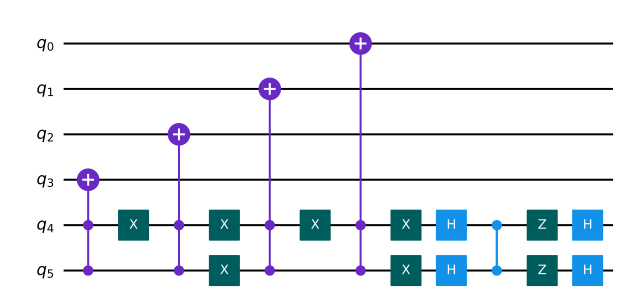

In [4]:
one_step_circuit.inverse().draw() 

The inversed one step gate will be used to reverse the phase estimation later. We need to make controlled gates from both the one step gate that we implemented in section 3 and its inverse. We will later use them depending on the value of the control qubit.  

In [5]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

Both the controlled one step gate and the controlled inversed one step gate will be used in the phase estimation. Another thing we will use in the phase estimation is the Quantum Fourier Transform. Qiskit has a function, QFT, which implements the Quantum Fourier Transform. The phase estimation uses the inverse Quantum Fourier Transform but we also will need to use the ordinary QFT to reverse the phase estimation.

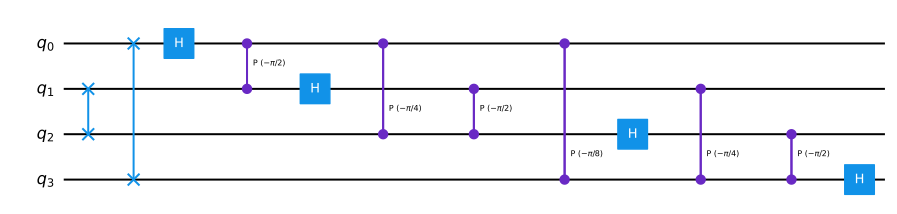

In [6]:
inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose().draw("mpl")

Before we implement the phase estimation, we implement a phase oracle that marks the states 1011 and 1111. Then, we make it a circuit. This is step 2(a) of the algorithm.

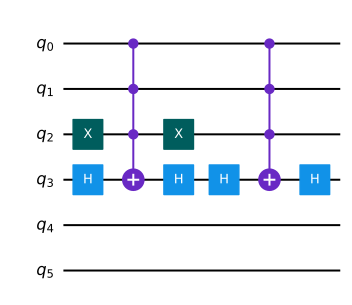

In [7]:
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Mark 1011
phase_circuit.x(2)
phase_circuit.h(3)
phase_circuit.mct([0,1,2], 3)
phase_circuit.h(3)
phase_circuit.x(2)
# Mark 1111
phase_circuit.h(3)
phase_circuit.mct([0,1,2],3)
phase_circuit.h(3)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw() 

We will now implement a gate that rotates an auxiliary qubit if the other qubits are non-zero. We will use this gate in the phase estimation, where it will rotate the auxiliary qubit if $\theta \neq 0$. 

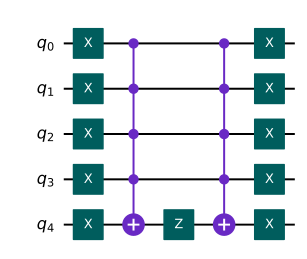

In [8]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mct([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

Now, we will implement step 2(b) of the algorithm. This step consists of a phase estimation one step of the quantum walk followed by an auxiliary qubit that we rotate if $\theta \neq 0$. For this, we use the mark_auxiliary_gate that we just created.  Thereafter, we reverse the phase estimation. 

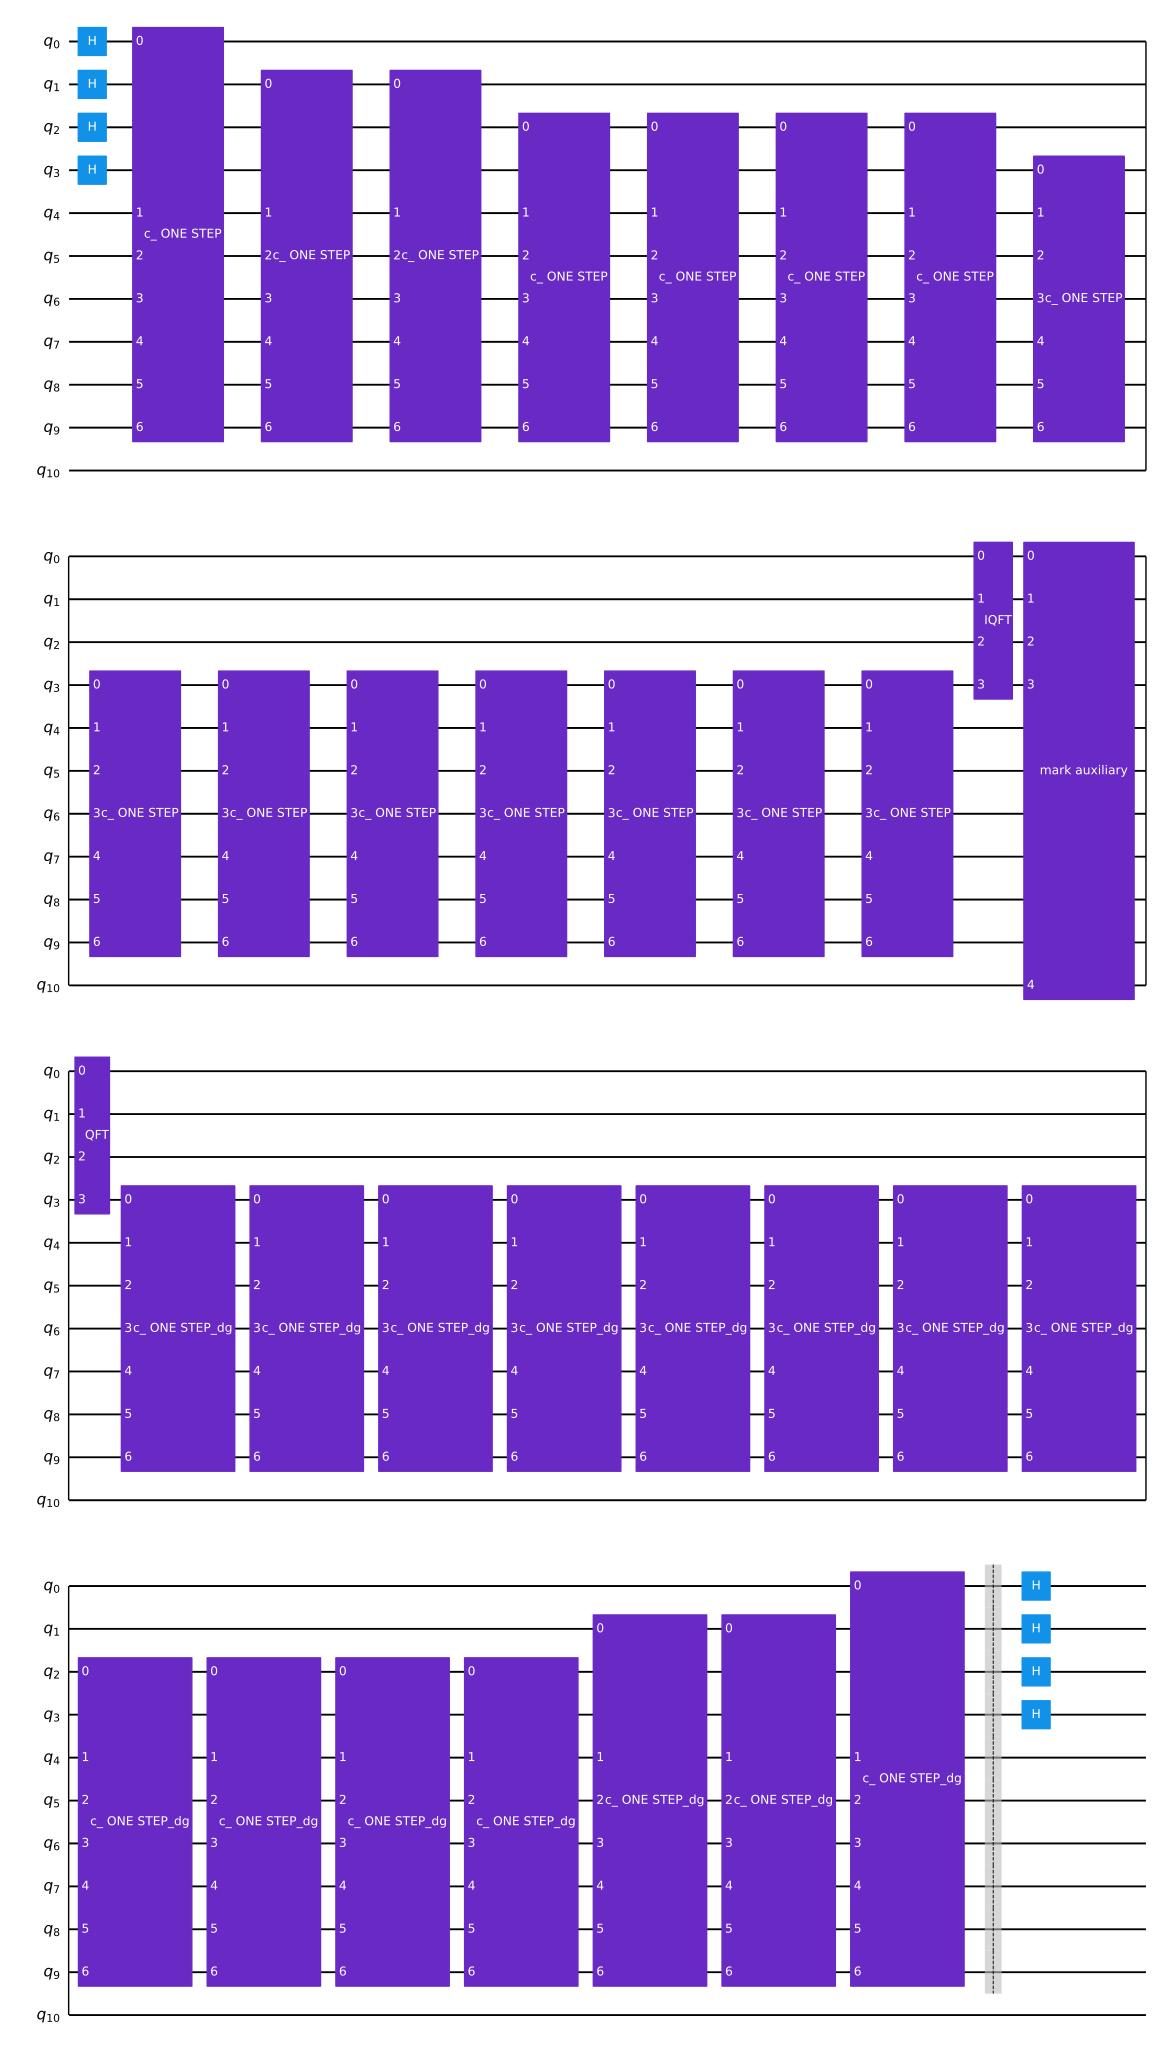

In [9]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw() 

Now we implement the whole quantum walk search algorithm using the gates we made previously. We start by applying Hadamard gates to node and coin qubits, which is step 1 in the algorithm. Thereafter, we iteratively apply the phase oracle gate and the phase estimation gate (steps 2(a) and 2(b)). We need $O(1/\sqrt{\epsilon})$ iterations as stated in the description of the algorithm in section 4. Lastly, we measure the node qubits. 

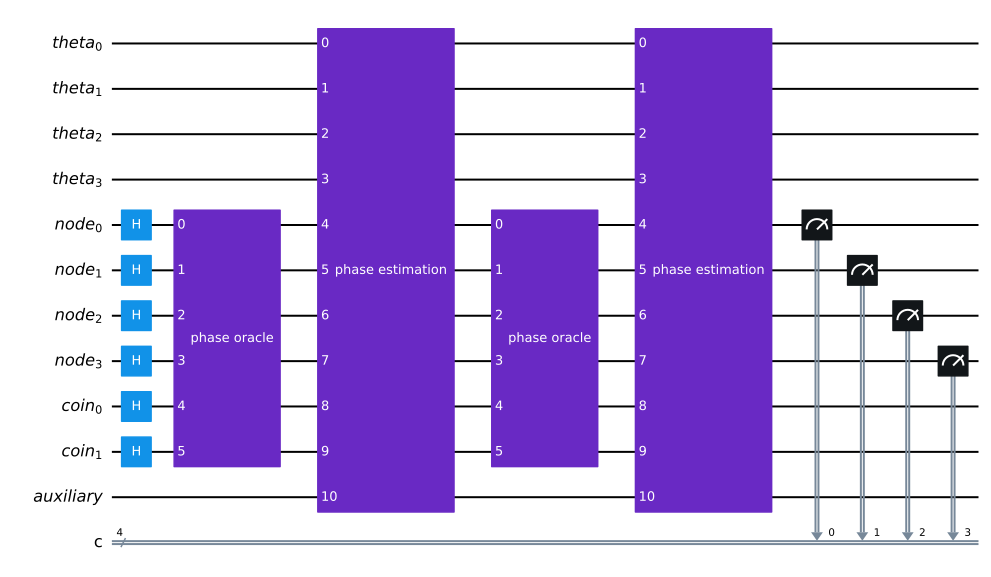

In [10]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([4,5,6,7,8,9])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[0])
circuit.measure(node_q[1], creg_c2[1])
circuit.measure(node_q[2], creg_c2[2])
circuit.measure(node_q[3], creg_c2[3])
circuit.draw()

Finally we run the implementation on the qasm simulator. We see that the circuit collapse to the marked states a clear majority of the times. 

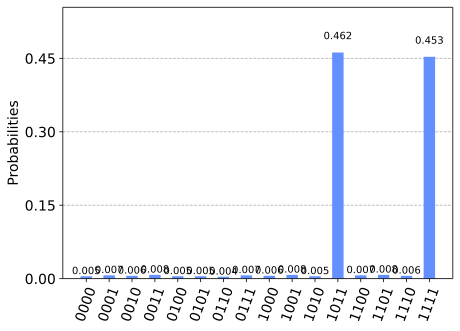

In [11]:
backend = Aer.get_backend('qasm_simulator') 
job = execute( circuit, backend, shots=1024 ) 
hist = job.result().get_counts() 
plot_histogram( hist )

## 6. References <a id='references'></a>

1. Renato Portugal. Quantum Walks and Search Algorithms. New York, NY: Springer New York, 2013
2. Markus G. Kuhn.Some Introductory Notes on Quantum Computing. Apr. 2000
3. Thomas G. Wong. “Equivalence of Szegedy’s and coined quantum walks”. In: Quantum InformationProcessing 16.9 (July 2017). ISSN: 1573-1332. DOI:10.1007/s11128-017-1667-y. URL:http://dx.doi.org/10.1007/s11128-017-1667-y.37
4. Ronald de Wolf. Quantum Computing: Lecture Notes. 2021. arXiv:1907.09415 [quant-ph]

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/envs/terra-unstable/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
